In [6]:
import cv2
import os
import glob
import numpy as np

# ================= CONFIG =================
INPUT_FOLDER = r"synthetic_dataset\images_before"   # תיקיית המקור
OUTPUT_FOLDER = "train_data"            # תיקיית היעד
CROP_SIZE = (512, 512)                  # גודל התוצאה הסופית
DISPLAY_WIDTH = 1000                    # רוחב התמונה בחלון התצוגה (פיקסלים)
# ==========================================

# יצירת תיקיות פלט
bg_dir = os.path.join(OUTPUT_FOLDER, "backgrounds")
door_dir = os.path.join(OUTPUT_FOLDER, "doors")
os.makedirs(bg_dir, exist_ok=True)
os.makedirs(door_dir, exist_ok=True)

# משתנים גלובליים
drawing = False
ix, iy = -1, -1
img_display = None
img_raw = None
current_crop = None
scale_factor = 1.0  # משתנה חדש לשמירת היחס

def get_next_filename(folder, prefix):
    """מוצא את המספר הפנוי הבא לשמירה"""
    existing = glob.glob(os.path.join(folder, f"{prefix}_*.png"))
    if not existing:
        return f"{prefix}_01.png"
    
    nums = []
    for f in existing:
        try:
            name = os.path.basename(f)
            num = int(name.split('_')[1].split('.')[0])
            nums.append(num)
        except: pass
    
    if not nums: return f"{prefix}_01.png"
    next_num = max(nums) + 1
    return f"{prefix}_{next_num:02d}.png"

def draw_rect(event, x, y, flags, param):
    global ix, iy, drawing, img_display, img_raw, current_crop, scale_factor

    # טיפול בלחיצה
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    # טיפול בגרירה (ציור המלבן הירוק על התצוגה)
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_copy = img_display.copy()
            cv2.rectangle(img_copy, (ix, iy), (x, y), (0, 255, 0), 2)
            cv2.imshow("Data Cropper", img_copy)

    # טיפול בשחרור (ביצוע החיתוך בפועל)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.rectangle(img_display, (ix, iy), (x, y), (0, 255, 0), 2)
        cv2.imshow("Data Cropper", img_display)

        # --- התיקון הקריטי: המרת קואורדינטות מהמסך לתמונה המקורית ---
        orig_ix = int(ix / scale_factor)
        orig_iy = int(iy / scale_factor)
        orig_x = int(x / scale_factor)
        orig_y = int(y / scale_factor)

        # חישוב גבולות החיתוך
        x_start, x_end = min(orig_ix, orig_x), max(orig_ix, orig_x)
        y_start, y_end = min(orig_iy, orig_y), max(orig_iy, orig_y)
        
        # בדיקת תקינות (שהחיתוך לא קטן מדי)
        if x_end - x_start > 10 and y_end - y_start > 10:
            # הגנה מפני חריגה מגבולות התמונה
            h, w = img_raw.shape[:2]
            x_start = max(0, x_start)
            y_start = max(0, y_start)
            x_end = min(w, x_end)
            y_end = min(h, y_end)

            # חיתוך מתוך התמונה המקורית (ברזולוציה הגבוהה)
            crop = img_raw[y_start:y_end, x_start:x_end]
            
            if crop.size > 0:
                # שינוי גודל ל-512x512 עבור האימון
                current_crop = cv2.resize(crop, CROP_SIZE, interpolation=cv2.INTER_AREA)
                
                # הצגת התוצאה
                cv2.imshow("Preview (512x512)", current_crop)
                print(f"\n✅ Selected area: {x_start},{y_start} to {x_end},{y_end}")
                print("Press 'b' for Background, 'd' for Door, or crop again.")

def main():
    global img_display, img_raw, current_crop, scale_factor
    
    extensions = ['*.jpg', '*.png', '*.jpeg']
    files = []
    for ext in extensions:
        files.extend(glob.glob(os.path.join(INPUT_FOLDER, ext)))
    
    print(f"Found {len(files)} images. Starting tool...")
    print(f"Display width set to: {DISPLAY_WIDTH}px")
    
    cv2.namedWindow("Data Cropper")
    cv2.setMouseCallback("Data Cropper", draw_rect)

    for f_path in files:
        img_raw = cv2.imread(f_path)
        if img_raw is None: continue
        
        # --- חישוב שינוי הגודל לתצוגה ---
        h, w = img_raw.shape[:2]
        scale_factor = DISPLAY_WIDTH / float(w)
        new_height = int(h * scale_factor)
        
        # יצירת תמונה מוקטנת לתצוגה
        img_display = cv2.resize(img_raw, (DISPLAY_WIDTH, new_height), interpolation=cv2.INTER_AREA)
        
        cv2.imshow("Data Cropper", img_display)
        print(f"\nProcessing: {os.path.basename(f_path)}")
        
        while True:
            key = cv2.waitKey(1) & 0xFF

            if key == ord('b'): # שמירת רקע
                if current_crop is not None:
                    fname = get_next_filename(bg_dir, "bg")
                    save_path = os.path.join(bg_dir, fname)
                    cv2.imwrite(save_path, current_crop)
                    print(f"💾 Saved BACKGROUND: {fname}")
                    # הבהוב ירוק
                    flash = np.full_like(current_crop, (0, 255, 0))
                    cv2.imshow("Preview (512x512)", cv2.addWeighted(current_crop, 0.7, flash, 0.3, 0))
                    cv2.waitKey(200)
                    cv2.imshow("Preview (512x512)", current_crop)

            elif key == ord('d'): # שמירת דלת
                if current_crop is not None:
                    fname = get_next_filename(door_dir, "door")
                    save_path = os.path.join(door_dir, fname)
                    cv2.imwrite(save_path, current_crop)
                    print(f"💾 Saved DOOR: {fname}")
                    # הבהוב כחול
                    flash = np.full_like(current_crop, (255, 0, 0))
                    cv2.imshow("Preview (512x512)", cv2.addWeighted(current_crop, 0.7, flash, 0.3, 0))
                    cv2.waitKey(200)
                    cv2.imshow("Preview (512x512)", current_crop)

            elif key == ord(' '): # תמונה הבאה
                print(">>> Next Image")
                break
            
            elif key == ord('q'): # יציאה
                print("Exiting...")
                cv2.destroyAllWindows()
                return

    cv2.destroyAllWindows()
    print("Done!")

if __name__ == "__main__":
    main()

Found 455 images. Starting tool...
Display width set to: 1000px

Processing: image_003.jpg

✅ Selected area: 232,387 to 273,478
Press 'b' for Background, 'd' for Door, or crop again.
💾 Saved DOOR: door_01.png
>>> Next Image

Processing: image_004.jpg

✅ Selected area: 3164,1244 to 3680,1472
Press 'b' for Background, 'd' for Door, or crop again.
💾 Saved DOOR: door_02.png
>>> Next Image

Processing: image_005.jpg

✅ Selected area: 164,117 to 209,156
Press 'b' for Background, 'd' for Door, or crop again.
💾 Saved BACKGROUND: bg_01.png
>>> Next Image

Processing: image_006.jpg

✅ Selected area: 533,581 to 602,732
Press 'b' for Background, 'd' for Door, or crop again.
💾 Saved DOOR: door_03.png
>>> Next Image

Processing: image_007.jpg

✅ Selected area: 333,72 to 377,115
Press 'b' for Background, 'd' for Door, or crop again.
💾 Saved BACKGROUND: bg_02.png
>>> Next Image

Processing: image_008.jpg

✅ Selected area: 361,367 to 418,416
Press 'b' for Background, 'd' for Door, or crop again.
💾 Save

In [7]:
import os
import json
import glob

# ================= CONFIG =================
TRAIN_DATA_FOLDER = "train_data"
# ==========================================

# הגדרת הפרומפטים המדויקים לכל סוג
PROMPTS = {
    "background": "top down view of architectural floor plan background, clean tiles, empty space, seamless texture",
    "door": "architectural symbol of a double door, 2sdoor, two door leaves swinging open, top down view, cad drawing"
}

def main():
    # חיפוש כל התמונות בתיקיות המשנה שהכלי הקודם יצר
    # (הכלי שמר ב-train_data/backgrounds ו-train_data/doors)
    bg_files = glob.glob(os.path.join(TRAIN_DATA_FOLDER, "backgrounds", "*.png"))
    door_files = glob.glob(os.path.join(TRAIN_DATA_FOLDER, "doors", "*.png"))
    
    all_entries = []

    # 1. עיבוד הרקעים
    print(f"Found {len(bg_files)} background images...")
    for f_path in bg_files:
        # אנחנו צריכים את הנתיב היחסי מתוך תיקיית train_data
        # לדוגמה: "backgrounds/bg_01.png"
        rel_path = os.path.relpath(f_path, TRAIN_DATA_FOLDER).replace("\\", "/")
        
        entry = {
            "file_name": rel_path,
            "text": PROMPTS["background"]
        }
        all_entries.append(entry)

    # 2. עיבוד הדלתות
    print(f"Found {len(door_files)} door images...")
    for f_path in door_files:
        rel_path = os.path.relpath(f_path, TRAIN_DATA_FOLDER).replace("\\", "/")
        
        entry = {
            "file_name": rel_path,
            "text": PROMPTS["door"]
        }
        all_entries.append(entry)

    # 3. שמירת הקובץ
    output_path = os.path.join(TRAIN_DATA_FOLDER, "metadata.jsonl")
    with open(output_path, 'w') as f:
        for entry in all_entries:
            f.write(json.dumps(entry) + "\n")

    print(f"✅ Success! Created {output_path} with {len(all_entries)} items.")
    print("You are ready to train.")

if __name__ == "__main__":
    main()

Found 28 background images...
Found 28 door images...
✅ Success! Created train_data\metadata.jsonl with 56 items.
You are ready to train.


In [1]:
import os
import json
import torch
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from peft import LoraConfig, get_peft_model
from torch.cuda.amp import autocast, GradScaler # <-- לרכיב המהירות

# --- CONFIGURATION ---
DATA_DIR = "train_data"
OUTPUT_DIR = "lora_weights_v2"
MODEL_NAME = "runwayml/stable-diffusion-v1-5" # המודל התקין שבחרנו
STEPS = 800                   # הורדנו ל-800 (יחסוך 30% מהזמן ועדיין יעיל)
LEARNING_RATE = 1e-4
BATCH_SIZE = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class MultiConceptDataset(Dataset):
    def __init__(self, folder, tokenizer):
        self.data = []
        self.folder = folder
        json_path = os.path.join(folder, "metadata.jsonl")
        if not os.path.exists(json_path):
            raise FileNotFoundError(f"Missing metadata.jsonl in {folder}")
        
        with open(json_path, 'r') as f:
            for line in f:
                self.data.append(json.loads(line))
                
        self.transform = transforms.Compose([
            transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(512),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
        self.tokenizer = tokenizer

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.folder, item["file_name"])
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            return self.__getitem__(0)

        pixel_values = self.transform(image)
        text_inputs = self.tokenizer(
            item["text"], 
            padding="max_length", 
            max_length=self.tokenizer.model_max_length, 
            truncation=True, 
            return_tensors="pt"
        )
        return {"pixel_values": pixel_values, "input_ids": text_inputs.input_ids[0]}

def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"🚀 Initializing Training on {DEVICE} with Mixed Precision...")
    
    # 1. Load Models
    tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder").to(DEVICE)
    vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae").to(DEVICE)
    unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet").to(DEVICE)
    noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")

    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    unet.requires_grad_(False)

    # 2. Setup LoRA
    lora_config = LoraConfig(
        r=16, 
        lora_alpha=32,
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
        lora_dropout=0.05,
        bias="none",
    )
    unet = get_peft_model(unet, lora_config)
    
    # 3. Optimizer & Scaler (for FP16)
    optimizer = torch.optim.AdamW(unet.parameters(), lr=LEARNING_RATE)
    scaler = GradScaler() # מנהל את הדיוק המעורב

    dataset = MultiConceptDataset(DATA_DIR, tokenizer)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 4. Training Loop
    print(f"🏋️ Starting fast training for {STEPS} steps...")
    unet.train()
    
    # הגדרות Progress Bar שלא ייתקע
    progress_bar = tqdm(range(STEPS), desc="Training", unit="steps", mininterval=1.0)
    global_step = 0
    running_loss = 0.0

    while global_step < STEPS:
        for batch in dataloader:
            # Latents (ללא שינוי)
            with torch.no_grad():
                latents = vae.encode(batch["pixel_values"].to(DEVICE)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                
                # Text Embeddings
                encoder_hidden_states = text_encoder(batch["input_ids"].to(DEVICE))[0]

            # Noise
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=DEVICE)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # --- הבלוק המאיץ (FP16) ---
            with autocast():
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

            # Backprop עם Scaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            # --------------------------
            
            # עדכון בר התקדמות
            running_loss += loss.item()
            global_step += 1
            progress_bar.update(1)
            
            if global_step % 10 == 0:
                progress_bar.set_postfix(loss=f"{running_loss/10:.4f}")
                running_loss = 0.0
            
            if global_step >= STEPS: break

    print("💾 Saving LoRA weights...")
    unet.save_pretrained(OUTPUT_DIR)
    print(f"✅ Done! Model saved to {OUTPUT_DIR}")

if __name__ == "__main__":
    main()

c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Initializing Training on cuda with Mixed Precision...


C:\Users\adiha\AppData\Local\Temp\ipykernel_46984\3409101863.py:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # מנהל את הדיוק המעורב


🏋️ Starting fast training for 800 steps...


Training:   0%|          | 0/800 [00:00<?, ?steps/s]C:\Users\adiha\AppData\Local\Temp\ipykernel_46984\3409101863.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 800/800 [09:06<00:00,  1.47steps/s, loss=0.0453]

💾 Saving LoRA weights...
✅ Done! Model saved to lora_weights_v2


Loading DETR...
Loading SAM...
Loading SD Inpaint...


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Other

✅ Loaded fine-tune as LoRA.
picked: ('stove', 0.4630667567253113, 869.9735382793006)
✅ DETR picked: stove score=0.463 area=870.0 box=[137, 49, 185, 92]


100%|██████████| 31/31 [00:47<00:00,  1.54s/it]


✅ Saved: eval_outputs_sam_delete_door\seed_0042_before/before_box/crop/mask/after.png


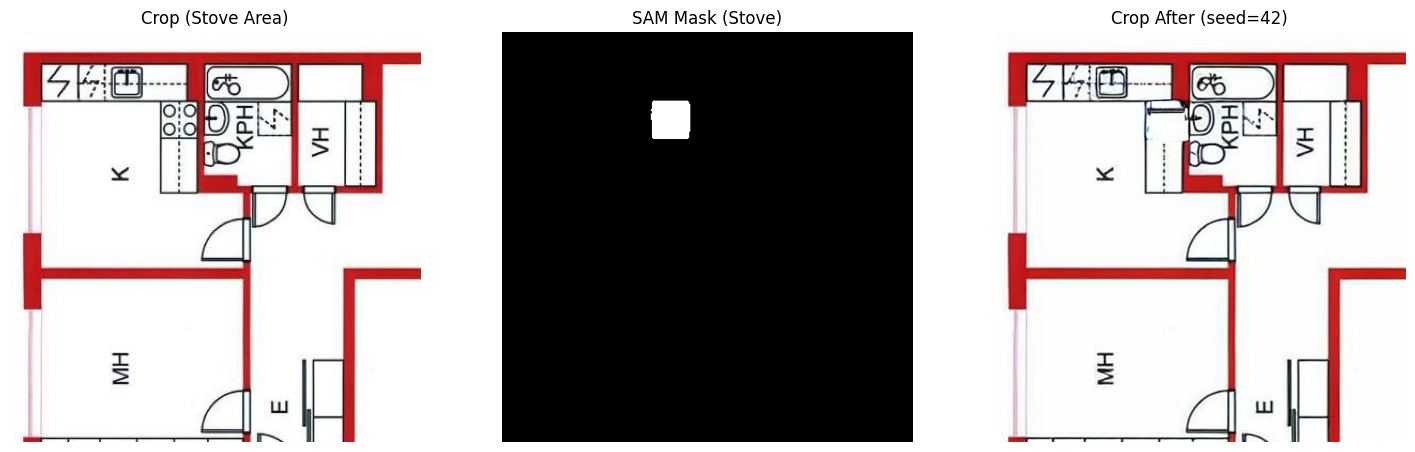

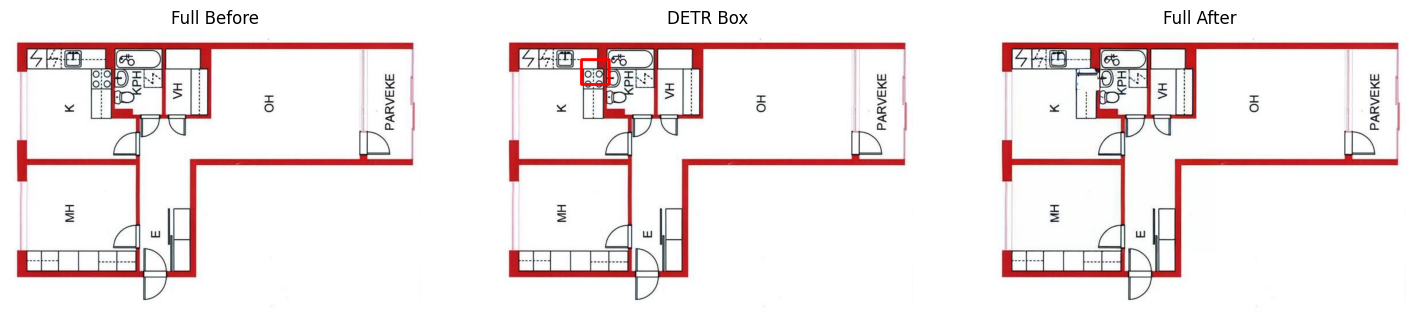

DONE ✅


In [14]:
import os
import numpy as np
from PIL import Image
import cv2
import torch
import matplotlib.pyplot as plt

from transformers import DetrImageProcessor, DetrForObjectDetection
from segment_anything import sam_model_registry, SamPredictor
from diffusers import StableDiffusionInpaintPipeline, UNet2DConditionModel

# =========================
# CONFIG
# =========================
TEST_IMAGE_PATH = r"TestPlans\testPlan3.PNG"
OUTPUT_DIR      = r"eval_outputs_sam_delete_door"

DETR_MODEL_DIR  = r"Model\detr-finetuned-floorplans"
SAM_CHECKPOINT  = r"checkpoints\sam_vit_h_4b8939.pth"

BASE_SD_MODEL   = "runwayml/stable-diffusion-v1-5"
FINETUNE_DIR    = r"lora_weights_v2"  # LoRA OR full UNet dir

TARGET_LABEL_SUBSTR = None  # None -> pick labels containing "door"
DETR_THRESH = 0.4

# Cropping for SD stability
CROP_SIZE = 384
BOX_PAD_PIXELS = 8          # small pad only
SAM_REFINE_DILATE = 1        # small
SAM_REFINE_CLOSE  = 1        # small
MASK_BLUR_SIGMA   = 0.3     # small feather to avoid hard edge

# SD delete prompt
PROMPT_DELETE = "top down view of architectural floor plan background, clean tiles, empty space, seamless texture"
NEG_PROMPT    = "stove, cooktop, hob, burners, kitchen appliance, text, watermark, noisy, blurry"

SEEDS    = [42]
STRENGTH = 0.90
GUIDANCE = 7.5
STEPS    = 35

# =========================
# CUDA / FP16
# =========================
assert torch.cuda.is_available(), "CUDA not available."
DEVICE = "cuda"
DTYPE  = torch.float16
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

os.makedirs(OUTPUT_DIR, exist_ok=True)

# =========================
# Helpers
# =========================
def clamp_box_xyxy(box, w, h):
    x0,y0,x1,y1 = box
    x0 = int(max(0, min(w-1, x0)))
    y0 = int(max(0, min(h-1, y0)))
    x1 = int(max(1, min(w,   x1)))
    y1 = int(max(1, min(h,   y1)))
    return [x0,y0,x1,y1]

def expand_box_xyxy(box, w, h, pad=18):
    x0,y0,x1,y1 = box
    return [
        max(0, int(x0-pad)),
        max(0, int(y0-pad)),
        min(w, int(x1+pad)),
        min(h, int(y1+pad)),
    ]

def pad_to_square_crop_center(box, w, h, crop_size=512):
    x0,y0,x1,y1 = box
    cx = (x0+x1)/2.0
    cy = (y0+y1)/2.0
    half = crop_size/2.0
    cx0 = int(round(cx-half)); cy0 = int(round(cy-half))
    cx1 = cx0 + crop_size;     cy1 = cy0 + crop_size

    if cx0 < 0: cx1 += -cx0; cx0 = 0
    if cy0 < 0: cy1 += -cy0; cy0 = 0
    if cx1 > w:
        shift = cx1 - w
        cx0 = max(0, cx0-shift); cx1 = w
    if cy1 > h:
        shift = cy1 - h
        cy0 = max(0, cy0-shift); cy1 = h

    cx0 = max(0, min(w-1, cx0))
    cy0 = max(0, min(h-1, cy0))
    cx1 = max(1, min(w, cx1))
    cy1 = max(1, min(h, cy1))
    return [cx0,cy0,cx1,cy1]

def draw_box(img_pil, box, color=(255,0,0), thickness=3):
    im = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(im, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(im)

def refine_mask(mask_np, dilate=2, close_iter=1, blur_sigma=0.8):
    m = (mask_np.astype(np.uint8) * 255)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate*2+1, dilate*2+1))
    if dilate > 0:
        m = cv2.dilate(m, k, iterations=1)
    if close_iter > 0:
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k, iterations=close_iter)
    if blur_sigma and blur_sigma > 0:
        m = cv2.GaussianBlur(m, (0,0), sigmaX=float(blur_sigma))
    return m

def show_triplet(a, b, c, titles=("Before", "Mask", "After")):
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1); plt.title(titles[0]); plt.imshow(a); plt.axis("off")
    plt.subplot(1,3,2); plt.title(titles[1]); plt.imshow(b, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title(titles[2]); plt.imshow(c); plt.axis("off")
    plt.show()

# =========================
# Load DETR
# =========================
print("Loading DETR...")
detr_processor = DetrImageProcessor.from_pretrained(DETR_MODEL_DIR)
detr_model = DetrForObjectDetection.from_pretrained(DETR_MODEL_DIR).to(DEVICE)
detr_model.eval()
id2label = detr_model.config.id2label

def detr_best_box(image_pil, thresh=0.25, label_substr="stove"):
    inputs = detr_processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = detr_model(**inputs)

    target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
    res = detr_processor.post_process_object_detection(outputs, threshold=thresh, target_sizes=target_sizes)[0]

    labels = res["labels"].detach().cpu().numpy()
    scores = res["scores"].detach().cpu().numpy()
    boxes  = res["boxes"].detach().cpu().numpy()

    cand = []
    for lab, sc, bx in zip(labels, scores, boxes):
        name = id2label.get(int(lab), str(lab))
        if label_substr.lower() not in name.lower():
            continue
        x0,y0,x1,y1 = bx.tolist()
        area = max(1.0, (x1-x0)*(y1-y0))
        cand.append((float(sc), area, bx.tolist(), name))

    if not cand:
        return None, None

    # pick by: highest score BUT prefer not-too-tiny boxes
    # (sort by score first, then by area)
    cand.sort(key=lambda x: (x[0], x[1]), reverse=True)
    sc, area, box, name = cand[0]
    return box, (name, sc, area)


# =========================
# Load SAM
# =========================
print("Loading SAM...")
sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

# =========================
# Load SD Inpaint + fine-tune
# =========================
print("Loading SD Inpaint...")
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    BASE_SD_MODEL, torch_dtype=DTYPE, safety_checker=None
).to(DEVICE)
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception:
    pass
pipe.enable_attention_slicing()

loaded = False
try:
    pipe.load_lora_weights(FINETUNE_DIR)
    pipe.fuse_lora(lora_scale=0.8)
    loaded = True
    print("✅ Loaded fine-tune as LoRA.")
except Exception:
    pass

if not loaded:
    pipe.unet = UNet2DConditionModel.from_pretrained(FINETUNE_DIR, torch_dtype=DTYPE).to(DEVICE)
    print("✅ Loaded fine-tune as full UNet.")

# =========================
# SAM with BOX + POSITIVE POINTS (KEY FIX)
# =========================
def sam_mask_box_plus_points(crop_rgb_np, box_xyxy_crop):
    sam_predictor.set_image(crop_rgb_np)

    x0,y0,x1,y1 = map(float, box_xyxy_crop)
    box = np.array([x0,y0,x1,y1], dtype=np.float32)

    cx = (x0+x1)/2.0
    cy = (y0+y1)/2.0
    w  = (x1-x0)
    h  = (y1-y0)

    # 2 positive points inside stove + 1 negative just outside
    pos1 = [cx, cy]
    pos2 = [cx + 0.15*w, cy + 0.15*h]

    # negative point slightly outside the box (to avoid grabbing nearby walls/lines)
    neg1 = [x1 + 0.10*w, y1 + 0.10*h]

    point_coords = np.array([pos1, pos2, neg1], dtype=np.float32)
    point_labels = np.array([1, 1, 0], dtype=np.int32)

    masks, scores, _ = sam_predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        box=box,
        multimask_output=True
    )

    # choose best by score, but punish too-big masks
    box_area = max(1.0, w*h)
    best_i, best_val = 0, -1e9
    for i in range(masks.shape[0]):
        area = float(masks[i].sum())
        frac = area / box_area
        penalty = 0.0
        if frac > 0.75:  # stove should not fill most of the box
            penalty = (frac - 0.75) * 6.0
        val = float(scores[i]) - penalty
        if val > best_val:
            best_val = val
            best_i = i

    return masks[best_i]


# =========================
# RUN
# =========================
img_full = Image.open(TEST_IMAGE_PATH).convert("RGB")
W, H = img_full.size

best_box, info = detr_best_box(img_full, thresh=0.25, label_substr="stove")
print("picked:", info)
if best_box is None:
    raise RuntimeError("No stove detected. Lower DETR_THRESH or check the label name.")


best_name, best_score, best_area = info
best_box = clamp_box_xyxy(best_box, W, H)
best_box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD_PIXELS)
print(f"✅ DETR picked: {best_name} score={best_score:.3f} area={best_area:.1f} box={best_box}")


# Crop 512x512 around door (SD safety)
crop_xyxy = pad_to_square_crop_center(best_box, W, H, crop_size=CROP_SIZE)
cx0,cy0,cx1,cy1 = crop_xyxy
crop_pil = img_full.crop((cx0,cy0,cx1,cy1)).resize((CROP_SIZE, CROP_SIZE), Image.Resampling.LANCZOS)

# Convert full-box to crop coordinates (scale!)
scale_x = CROP_SIZE / max(1, (cx1-cx0))
scale_y = CROP_SIZE / max(1, (cy1-cy0))
bx0,by0,bx1,by1 = best_box
box_in_crop = [
    (bx0 - cx0) * scale_x,
    (by0 - cy0) * scale_y,
    (bx1 - cx0) * scale_x,
    (by1 - cy0) * scale_y,
]

crop_np = np.array(crop_pil)  # RGB

# SAM mask (door-only)
mask_bool = sam_mask_box_plus_points(crop_np, box_in_crop)
mask_refined = refine_mask(mask_bool, dilate=SAM_REFINE_DILATE, close_iter=SAM_REFINE_CLOSE, blur_sigma=MASK_BLUR_SIGMA)
mask_pil = Image.fromarray(mask_refined).convert("L")

# SD inpaint on crop
last_out_full = None
last_out_crop = None
for seed in SEEDS:
    gen = torch.Generator(device=DEVICE).manual_seed(int(seed))
    out_crop = pipe(
        prompt=PROMPT_DELETE,
        negative_prompt=NEG_PROMPT,
        image=crop_pil,
        mask_image=mask_pil,
        strength=float(STRENGTH),
        guidance_scale=float(GUIDANCE),
        num_inference_steps=int(STEPS),
        generator=gen
    ).images[0]
    last_out_crop = out_crop

    # paste back
    out_crop_back = out_crop.resize((cx1-cx0, cy1-cy0), Image.Resampling.LANCZOS)
    out_full = img_full.copy()
    out_full.paste(out_crop_back, (cx0,cy0))
    last_out_full = out_full

    base = os.path.join(OUTPUT_DIR, f"seed_{seed:04d}")
    img_full.save(base + "_before.png")
    draw_box(img_full, best_box).save(base + "_before_box.png")
    crop_pil.save(base + "_crop.png")
    mask_pil.save(base + "_mask.png")
    out_full.save(base + "_after.png")
    print(f"✅ Saved: {base}_before/before_box/crop/mask/after.png")

# Show crop-level (most informative)
show_triplet(crop_pil, mask_pil, last_out_crop, titles=("Crop (Stove Area)", "SAM Mask (Stove)", f"Crop After (seed={SEEDS[-1]})"))
show_triplet(img_full, draw_box(img_full, best_box), last_out_full, titles=("Full Before", "DETR Box", "Full After"))
print("DONE ✅")
